In [1]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import swan
from importlib import reload
reload(swan)

# swan defaults
nx = 10
ny = 10
n = nx * ny
nsigma = 10
ntheta = 10
order = swan.order

# load input data
wd = os.path.join('..')
datadir = os.path.join(wd, "data_temp")
u10 = np.load(os.path.join(datadir, "speed.npz"))['array'][:ny, :nx]
theta = np.load(os.path.join(datadir, "direction.npz"))['array'][:ny, :nx]
swh = np.load(os.path.join(datadir, "sig_waves.npz"))['array'][:ny, :nx]
bathy = np.load(os.path.join(datadir, "bathymetry.npz"))['array'][:ny, :nx]
land = [bathy < 0]
bathy[bathy < 0] = 1e-5 # check correct solution here later

dx = np.load(os.path.join(datadir, "bathymetry.npz"))['mesh'].item()
dy = dx

# redefine nx, ny in case out of bounds
ny, nx = u10.shape
n = nx * ny
dims = [ntheta, nsigma, ny, nx]

# spectral grid
thetas = np.linspace(-np.pi, np.pi, ntheta) # always orient so 0 degrees points along x-axis (to coastline)
dtheta = thetas[1] - thetas[0]
sigmas, dsigma = swan.frequency_grid(nsigma, scale='linear')

# make meshgrids for all the inputs
u10 = u10.ravel(order=order)
theta = theta.ravel(order=order)
bathy = bathy.ravel(order=order)

_, _, H  = np.meshgrid(thetas, sigmas, bathy, indexing='ij')
_, dΣ, θm  = np.meshgrid(thetas, sigmas, theta, indexing='ij') # wind dir (assume mean wave dir)
θ, Σ, U10  = np.meshgrid(thetas, sigmas, u10, indexing='ij')
print(U10.shape)

(10, 10, 50)


1.3196220397949219
75.6087734326938
(10, 10, 50)


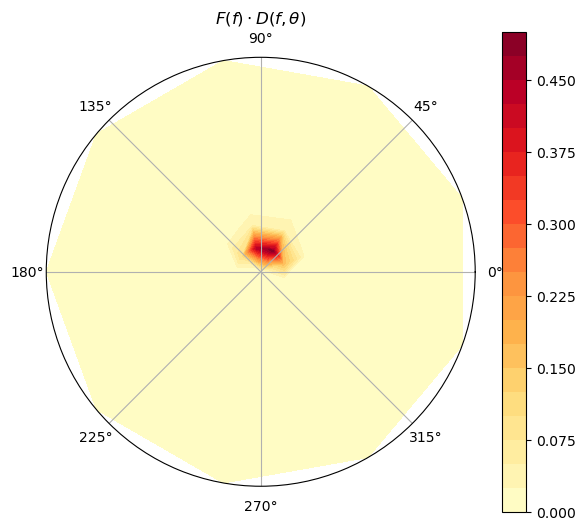

In [2]:
# set up grid values
Ef = swan.spectrum_pm(Σ, U10)
fpeak = swan.peak_frequency_pm(U10) / (2 * np.pi)
D = swan.cos2_model(θ, θm)
E = Ef * D

swan.polar_heatmap(Σ[..., 0], θ[..., 0], E[..., 0], rscale='linear', rticks=[])
print(np.unique(θm[..., 0]).item())
print(np.unique(θm[..., 0]).item() * (180 / np.pi))
print(E.shape)

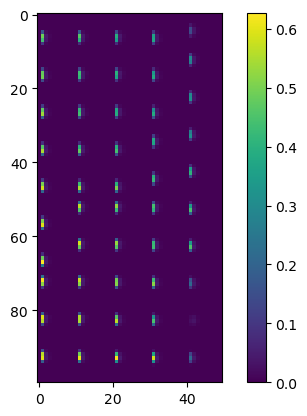

In [3]:
fig, ax = plt.subplots()
swan.flattened_heatmap(E, dims, which='z', ax=ax, cmap='Spectral_r');

## Velocities over spectrum 1: geographic
1. Find relative frequency based on wave numbers from directional frequency spectrum?

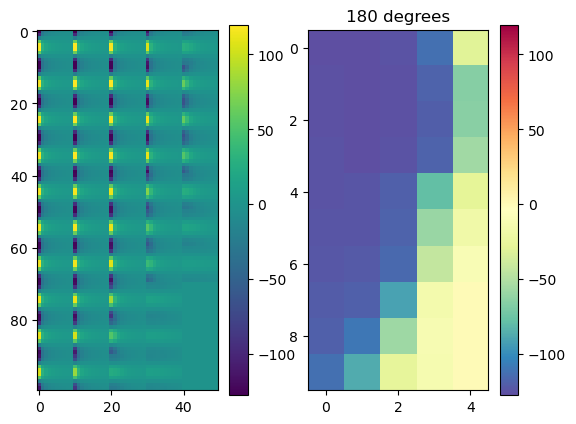

In [4]:
K = swan.inverse_dispersion_approx(Σ, H)
c = swan.phase_speed(K, Σ)
cg = swan.group_velocity(K, H, Σ)
cx, cy = swan.spatial_group_velocity(cg, θ)

var = cx
fig, axs = plt.subplots(1, 2)
swan.flattened_heatmap(var, dims, ax=axs[0], cmap='Spectral_r');
vmin = np.nanmin(var)
vmax = np.nanmax(var)

m, l = 9, 0 #np.random.randint(ntheta), np.random.randint(nsigma)
im = axs[1].imshow(var[m, l, ...].reshape([ny, nx], order=order), vmin=vmin, vmax=vmax, cmap='Spectral_r');
axs[1].set_title("{:.0f} degrees".format(thetas[m] * (180 / np.pi)))
plt.colorbar(im);

## Velocities over spectrum 2d: spectral

In [5]:
stepθ = 1
stepσ = ntheta
stepy = stepσ * nsigma
stepx = stepy * ny

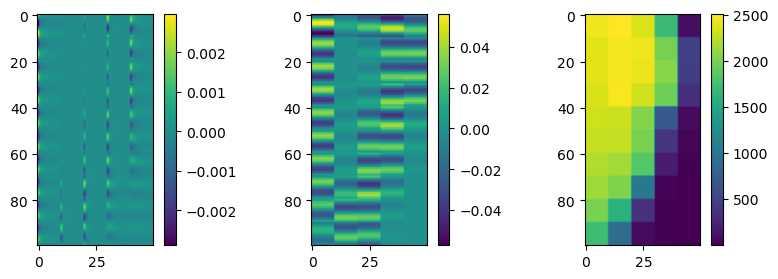

In [6]:
# refraction
cg = cg.ravel(order=order)
c = c.ravel(order=order)

A = swan.dfdm_central_diff(θ, stepx, stepy, dx, dy)

# swan.directional_velocity(θ, cg, c, setpz,)
cθ = (-cg / c) * A @ c

Ax = swan.dfdx_central_diff(A.shape[0], stepx, dx)
Ay = swan.dfdx_central_diff(A.shape[0], stepy, dy)
dH = A @ H.ravel(order=order)
dH = dH.reshape([ntheta, nsigma, n], order=order)

# plot results
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
cθ = cθ.reshape([ntheta, nsigma, n], order=order)
swan.flattened_heatmap(cθ, dims, ax=axs[0], cmap='Spectral_r');
swan.flattened_heatmap(dH, dims, ax=axs[1], cmap=cmo.deep);
swan.flattened_heatmap(H, dims, ax=axs[2], cmap=cmo.deep, vmin=0, vmax=2500);

In [7]:
# frequency shifting (see 2.13b)

## Solution matrix: geographic

In [8]:
# spatial
A_geo = swan.bsbt_matrix(stepx, stepy, cx, cy, dx, dy)
assert np.isclose(np.diag(A_geo, -stepy).sum(), -cy.ravel(order=order)[stepy:].sum() / dy)
assert np.isclose(np.diag(A_geo, -stepx).sum(), -cx.ravel(order=order)[stepx:].sum() / dx)

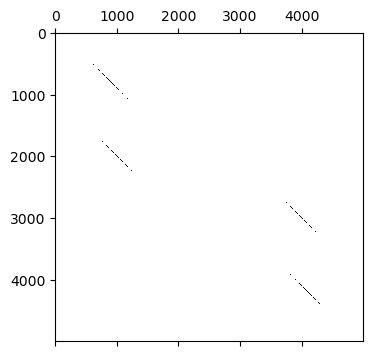

In [9]:
# spectral
A_spectral = swan.theta_block_matrix(cθ, stepθ)

fig, ax = plt.subplots(figsize=(4, 4))
ax.spy(A);

# Solve

In [10]:
dt = 10

A = A_geo + A_spectral
E.shape, Σ.shape
N = E / Σ
N = N.ravel(order=swan.order)

I = np.eye(ntheta * nsigma * nx * ny)
Ainv = np.linalg.inv(I + dt * A)
N1 = Ainv @ N

# Solution for T time steps

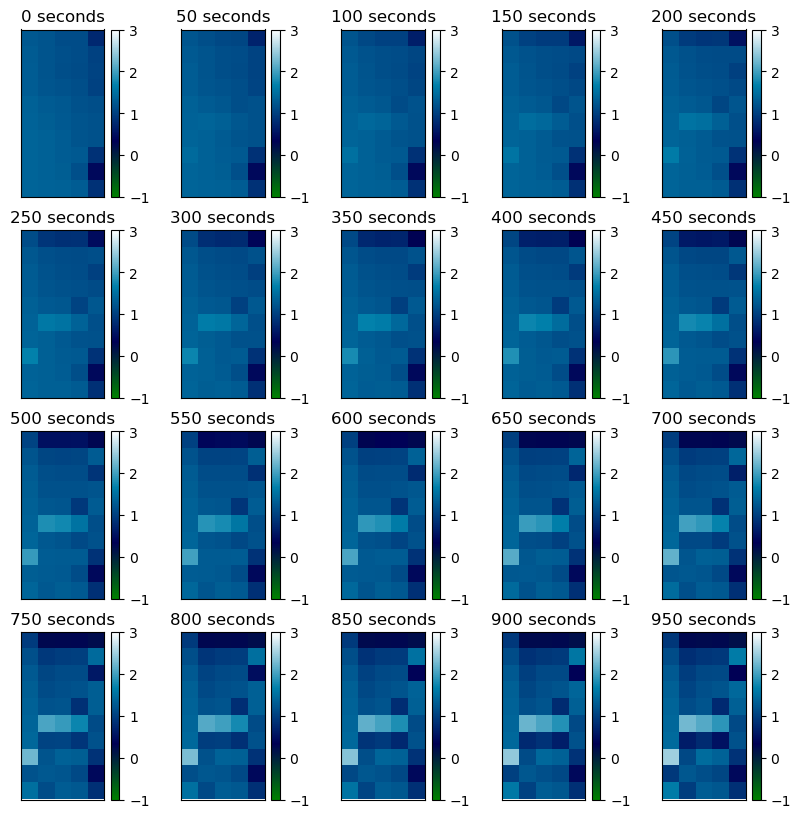

In [13]:
T = 100
fig, axs = plt.subplots(4, 5, figsize=(10, 10))

Hs_0 = swan.significant_wave_height(E, dtheta, dsigma[0]).reshape([ny, nx], order=order)
vmin, vmax = -1, 3
axs = axs.ravel()
nax = len(axs)

Hs_0 = ma.array(Hs_0, mask=land)
axs[0].imshow(Hs_0, vmin=vmin, vmax=vmax)

N1 = N.copy()
i = 0
for t in range(T):
    E1 = N1.reshape([ntheta, nsigma, ny * nx], order=order) * Σ
    E1 = swan.eliminate_negative_energies(E1, dtheta, ntheta)
    N1 = (E1 / Σ).ravel(order=order)
    if t % int(T / 20) == 0:
        Hs = swan.significant_wave_height(E1, dtheta, dsigma[0]).reshape([ny, nx], order=order)
        im = axs[i].imshow(Hs, cmap='ocean', vmin=vmin, vmax=vmax)
        plt.colorbar(im)
        axs[i].set_title(f"{t*dt} seconds")
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        i += 1
    N1 = Ainv @ N1

# Sweep quadrants
The Gauss-Seidel iteration process is done as follows. For each iteration, sweeping through grid rows and columns in geographical domain are carried out, starting from each of the four corners of the computational grid. After four sweeps, wave energy has been propagated over the entire geographical domain. During each sweep, only a subset of the unknown values of $N$ are updated depending on the sign of $c_x$ and $c_y$. For instance, the first sweep starts at the lower left hand corner and all grid points with $c_x > 0$ and $c_y > 0$ are updated. Because of the causality principle these transport velocities must be positive in those ordered grid points along the wave ray, in order to make a stable iterative update. Moreover, adapting the ordering of updates of the unknowns $N$ in geographical space to the propagation direction improves the rate of convergence of the Gauss-Seidel iterative procedure (Wesseling, 1992). For an illustrative explanation of this technique, see Section [3.5](https://swanmodel.sourceforge.io/online_doc/swantech/node44.html#sec:simple). 

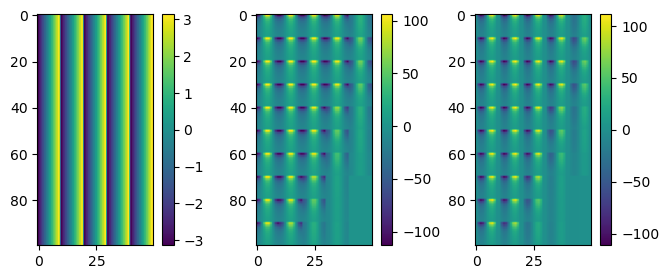

In [130]:
fig, axs = plt.subplots(1, 3, figsize=(8, 3))
swan.expanded_heatmap(θ, *dims, ax=axs[0]);
swan.expanded_heatmap(cx, *dims, ax=axs[1]);
swan.expanded_heatmap(cy, *dims, ax=axs[2]);

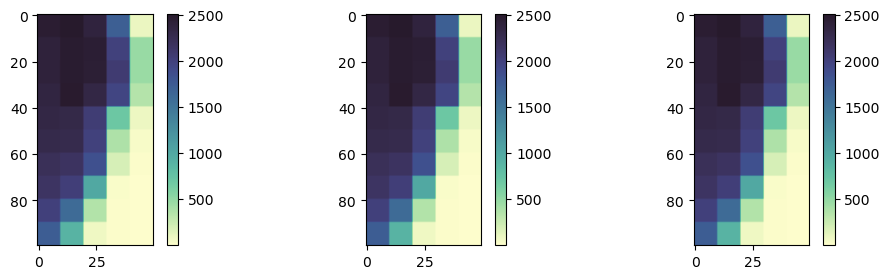

In [12]:
sweep = 1
H = H.reshape([ntheta, nsigma, ny, nx], order=order)
H_flipped = swan.flip_for_sweep(H, sweep)
H_back_again = swan.flip_for_sweep(H_flipped, sweep)

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
swan.expanded_heatmap(H, ntheta, nsigma, ny, nx, ax=axs[0], cmap=cmo.deep);
swan.expanded_heatmap(H_flipped, ntheta, nsigma, ny, nx, ax=axs[1], cmap=cmo.deep);
swan.expanded_heatmap(H_back_again, ntheta, nsigma, ny, nx, ax=axs[2], cmap=cmo.deep);

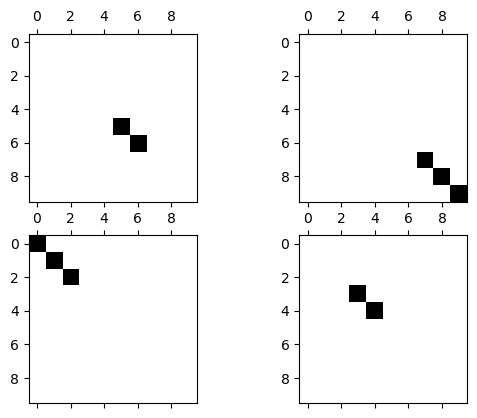

In [13]:
fig, axs = plt.subplots(2, 2)
axs = axs.ravel()
sweep = 1
N_sweep = swan.flip_for_sweep(H.reshape([ntheta, nsigma, ny, nx], order=swan.order), sweep)
cx_sweep, cy_sweep = swan.filter_cxcy_for_sweep(cx, cy, sweep)
A_sweep = swan.bsbt_matrix(stepx, stepy, cx_sweep, cy_sweep, dx, dy)
axs[0].spy(A_sweep[:10, :10])

sweep = 2
N_sweep = swan.flip_for_sweep(H.reshape([ntheta, nsigma, ny, nx], order=swan.order), sweep)
cx_sweep, cy_sweep = swan.filter_cxcy_for_sweep(cx, cy, sweep)
A_sweep = swan.bsbt_matrix(stepx, stepy, cx_sweep, cy_sweep, dx, dy)
axs[1].spy(A_sweep[:10, :10])

sweep = 3
N_sweep = swan.flip_for_sweep(H.reshape([ntheta, nsigma, ny, nx], order=swan.order), sweep)
cx_sweep, cy_sweep = swan.filter_cxcy_for_sweep(cx, cy, sweep)
A_sweep = swan.bsbt_matrix(stepx, stepy, cx_sweep, cy_sweep, dx, dy)
axs[2].spy(A_sweep[:10, :10])

sweep = 4
N_sweep = swan.flip_for_sweep(H.reshape([ntheta, nsigma, ny, nx], order=swan.order), sweep)
cx_sweep, cy_sweep = swan.filter_cxcy_for_sweep(cx, cy, sweep)
A_sweep = swan.bsbt_matrix(stepx, stepy, cx_sweep, cy_sweep, dx, dy)
axs[3].spy(A_sweep[:10, :10])

## Make 4 sets of matrices

In [147]:
# only need to filter by θ
# make this into a test:
N = E / Σ
condition_θ = (θ <= 0) & (θ > -np.pi/2)
print(cx[condition_θ].min(), cx[condition_θ].max())
print(cy[condition_θ].min(), cy[condition_θ].max())
N_sweep = np.where(condition_θ, N, 0)

0.004952271801910743 106.19099639083484
-97.86615164725971 -0.003387553422954361
